# Imports and Load Data

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # for visualisation
import numpy as np

from numpy import mean
from numpy import std
from numpy import arange

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Default plotting parameters
font = {'size'   : 18}
plt.rc('font', **font)

In [ ]:
# Load training dataset
rep = '/Users/Cherry0904/Desktop/MSc/Practicals/SML Practical/' 
y_train = pd.read_csv(rep + 'y_train.csv', index_col = 0, squeeze=True)
X_train = pd.read_csv(rep + 'X_train.csv', index_col = 0, header=[0, 1, 2]) #sets up header to be tuple
X_test = pd.read_csv(rep + 'X_test.csv', index_col = 0, header=[0, 1, 2])

# Create version with them together
Xy = pd.concat([X_train, y_train], axis = 1)

# StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_sd = scaler.transform(X_train)
X_test_sd = scaler.transform(X_test)

# Extract variable names (in the form of 'feature-statistics-number')
variable_names = X_train.keys().get_level_values(0).astype(str).values + ' - ' + X_train.keys().get_level_values(1).astype(str).values + ' - ' + X_train.keys().get_level_values(2).astype(str).values
print(variable_names[0:5,])

['chroma_cens - kurtosis - 01' 'chroma_cens - kurtosis - 02'
 'chroma_cens - kurtosis - 03' 'chroma_cens - kurtosis - 04'
 'chroma_cens - kurtosis - 05']


# Functions

The Export Function:

In [ ]:
# Function to format the predictions in a dataframe and export to a csv file, to be uploaded on kaggle
def export_to_csv(y_hat, filename):
    df = pd.DataFrame({'Genre': y_hat})
    df.index.name = 'Id'
    df.to_csv(filename)

Define the function that assesses performance for each classifier, using three repeats of 4-fold CV:

In [ ]:
def cv_clf(clf, X, y):
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=15)
    # evaluate model accuracy
    cv_results = cross_validate(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, return_train_score=True)
    ts_scores = cv_results['test_score']
    print('Mean Validation Accuracy: %.3f (%.3f)' % (mean(ts_scores), std(ts_scores)))

Define the grid search function for tuning parameters:

In [ ]:
def grid_search(clf, X, y, parameter, values):
    # define grid
    grid = dict()
    grid[parameter] = values
    # define search   
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
    search = GridSearchCV(clf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(X, y)
    # summarize
    print('Mean Validation Accuracy: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)

# LDA


Summary:
1. For Feature Selection, all three methods (ANOVA, RFE, Remove collinear vars) tried do not improve test accuracy.
<br>(Notice that when there is no shrinkage, both ANOVA and RFE improves the validation/test accuracy)
2. Projecting data on onto PCA/LDA coordinates does not improve test accuracy. 
3. No significant improvements by using different scalers.
4. No need to do polynomial input transformation, as it will certainly lead to overfitting.

### Feature Selection

In [ ]:
# Train-test split on scaled data
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.20 , random_state=15)

# Standardise data
scaler = StandardScaler() 
scaler.fit(X_tr)
X_tr_sd = scaler.transform(X_tr)
X_te_sd = scaler.transform(X_te)

Grid search the shrinkage parameter as below. Shrinkage parameter = 0.01 (does it mean the inverse?) offers a significant lift in performance. <br>
(solver = 'eigen': use eigendecomposition on the estimated covariance matrix - no need to compute the inverse)

0. All features used

In [ ]:
lda = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
print("No Shrinkage:")
cv_clf(lda, X_tr_sd, y_tr)

print("With Shrinkage:")
values=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, X_tr_sd, y_tr, 'shrinkage', values)

No Shrinkage:
Mean Validation Accuracy: 0.505 (0.135)
With Shrinkage:
Mean Validation Accuracy: 0.565
Config: {'shrinkage': 0.01}


In [ ]:
# train the shrinkage model on the full training set from train-test split 
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 0.01, store_covariance=True)
lda.fit(X_tr_sd,y_tr)
lda.score(X_te_sd,y_te) 

0.5591666666666667

1. ANOVA

In [ ]:
# ANOVA feature selection 
fs = SelectKBest(score_func=f_classif, k=300)
fs = fs.fit(X_tr_sd, y_tr)
X_tr_sel = fs.transform(X_tr_sd)
X_te_sel = fs.transform(X_te_sd)

In [ ]:
lda = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
print("No Shrinkage:")
cv_clf(lda, X_tr_sel, y_tr)

print("With Shrinkage:")
values=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, X_tr_sel, y_tr, 'shrinkage', values)

No Shrinkage:
Mean Validation Accuracy: 0.558 (0.018)
With Shrinkage:
Mean Validation Accuracy: 0.564
Config: {'shrinkage': 0.01}


In [ ]:
# train the shrinkage model on the full training set from train-test split 
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 0.01, store_covariance=True)
lda.fit(X_tr_sel,y_tr)
lda.score(X_te_sel,y_te) 

0.5525

2. RFE

In [ ]:
# RFE feature selection
rfe = RFE(estimator=LinearDiscriminantAnalysis(solver='eigen', store_covariance=True), n_features_to_select=300)
rfe = rfe.fit(X_tr_sd, y_tr)
X_tr_sel = rfe.transform(X_tr_sd)
X_te_sel = rfe.transform(X_te_sd)

In [ ]:
lda = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
print("No Shrinkage:")
cv_clf(lda, X_tr_sel, y_tr)

print("With Shrinkage:")
values=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, X_tr_sel, y_tr, 'shrinkage', values)

No Shrinkage:
Mean Validation Accuracy: 0.566 (0.014)
With Shrinkage:
Mean Validation Accuracy: 0.571
Config: {'shrinkage': 0.01}


In [ ]:
# train the shrinkage model on the full training set from train-test split 
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 0.01, store_covariance=True)
lda.fit(X_tr_sel,y_tr)
lda.score(X_te_sel,y_te) 

0.545

3. Remove Collinear Variables (with high VIF)

In [ ]:
# remove all features wit VIF greater than a threshold (to keep around 300 data points)
vif_train = pd.DataFrame()
vif_train["VIF Factor"] = [variance_inflation_factor(X_tr_sd, i) for i in range(X_tr_sd.shape[1])]

In [ ]:
index = vif_train["VIF Factor"] < 20
print(sum(index))
X_tr_sel = X_tr_sd[:, index] 
X_te_sel = X_te_sd[:, index] 

301


In [ ]:
lda = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
print("No Shrinkage:")
cv_clf(lda, X_tr_sel, y_tr)

print("With Shrinkage:")
values=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, X_tr_sel, y_tr, 'shrinkage', values)

No Shrinkage:
Mean Validation Accuracy: 0.495 (0.129)
With Shrinkage:
Mean Validation Accuracy: 0.544
Config: {'shrinkage': 0.01}


In [ ]:
# train the shrinkage model on the full training set from train-test split 
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 0.01, store_covariance=True)
lda.fit(X_tr_sel,y_tr)
lda.score(X_te_sel,y_te) 

0.5233333333333333

### Project data on PCA/LDA components

PCA/LDA for dimension reduction does not improve results.

In [ ]:
# Fit PCA projections on training data, obtain projections for both train and test
k = 10
PC = PCA(n_components = k)
PC.fit(X_tr_sd) 
ZPC_tr = PC.transform(X_tr_sd) 
ZPC_te = PC.transform(X_te_sd) 

# Fit LDA projections on training data, obtain projections for both train and test
LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_tr_sd, y_tr)
ZLDA_tr = LDA.transform(X_tr_sd)
ZLDA_te = LDA.transform(X_te_sd)

In [ ]:
print("First", k, "PCs:")
values=(1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, ZPC_tr, y_tr, 'shrinkage', values)

print("LDA Components:")
values=(1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, ZLDA_tr, y_tr, 'shrinkage', values)

First 10 PCs:
Mean Validation Accuracy: 0.381
Config: {'shrinkage': 1e-05}
LDA Components:
Mean Validation Accuracy: 0.673
Config: {'shrinkage': 1e-05}


Evaluate the LDA-transformed model on the held-out test set:

In [ ]:
# train the LDA-transformed model on the full training set from train-test split 
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 0.01, store_covariance=True)
lda.fit(ZLDA_tr,y_tr)
lda.score(ZLDA_te,y_te) 

0.5341666666666667

### Experiment with Other Scalers

Tried MinMaxScaler and QuantileTransformer. Overall, no other scalars have significantly improved test accuracy.

In [ ]:
# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_sel, y_train, test_size = 0.20 , random_state=15)

# Normalise data - suffer from outliers
scaler2 = MinMaxScaler()
scaler2.fit(X_tr)
X_tr_nr = scaler2.transform(X_tr)
X_te_nr = scaler2.transform(X_te)

# Quantile-transform to uniform - robust to outliers
scaler3 = QuantileTransformer(output_distribution='uniform')
scaler3.fit(X_tr)
X_tr_qu = scaler3.transform(X_tr)
X_te_qu = scaler3.transform(X_te)

# Quantile-transform to normal - robust to outliers
scaler4 = QuantileTransformer(output_distribution='normal')
scaler4.fit(X_tr)
X_tr_qn = scaler4.transform(X_tr)
X_te_qn = scaler4.transform(X_te)

1. Grid search and fit on test for Normalised data:

In [ ]:
# Grid search
values=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, X_tr_nr, y_tr, 'shrinkage', values)

Mean Validation Accuracy: 0.548
Config: {'shrinkage': 0.01}


In [ ]:
# validation accuracy
lda.fit(X_tr_nr,y_tr)
lda.score(X_te_nr,y_te)

0.5358333333333334

2. Grid search and fit on test for Uniform Scaled data:

In [ ]:
# Grid search
values=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, X_tr_qu, y_tr, 'shrinkage', values)

Mean Validation Accuracy: 0.557
Config: {'shrinkage': 0.01}


In [ ]:
# validation accuracy
lda.fit(X_tr_qu,y_tr)
lda.score(X_te_qu,y_te)

0.5233333333333333

3. Grid search and fit on test for Normal Scaled data:

In [ ]:
# Grid search
values=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.1))
grid_search(lda, X_tr_qn, y_tr, 'shrinkage', values)

Mean Validation Accuracy: 0.559
Config: {'shrinkage': 0.01}


In [ ]:
# validation accuracy
lda.fit(X_tr_qu,y_tr)
lda.score(X_te_qu,y_te)

0.5233333333333333

Fit the model on the full training data:

In [ ]:
# StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_sd = scaler.transform(X_train)
X_test_sd = scaler.transform(X_test)

LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage = 0.01, store_covariance=True)
LDA.fit(X_train_sd, y_train) 
y_hat = LDA.predict(X_test_sd)

# Export to CSV file 
# export_to_csv(y_hat,'Predictions_LDA.csv')

# Variable Importance (LDA)

Model: LDA with shrinkage = 0.01.

For linear classifiers, rank the variables by the mean of the coefficients b_{kj} across all k.

Comment: The feature mfcc and the statistics mean and median appear most frequently in the top 10 variables, so they can be view as "important".

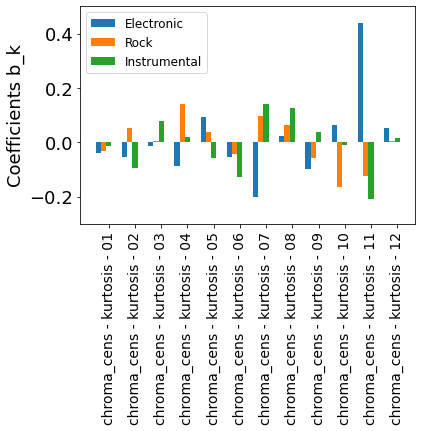

In [ ]:
# Visualise the coefficients b_{kj} for k=0..3, j=0..12
width = 0.2
plt.figure()
for k in np.arange(3):    
    plt.bar(np.arange(0,12)+width*k,LDA.coef_[k,0:12], tick_label=variable_names[0:12], width=width)
    plt.xticks(fontsize=14, rotation='vertical')
    plt.ylim([-0.3, 0.5])
    plt.ylabel('Coefficients b_k')    
plt.legend(['Electronic', 'Rock', 'Instrumental'], loc = 2, prop={'size': 12});

                            Variables  Coefficients
295                  mfcc - mean - 04      0.006569
409   spectral_centroid - median - 01     -0.006216
464      spectral_rolloff - mean - 01      0.005545
294                  mfcc - mean - 03     -0.004981
401    spectral_bandwidth - mean - 01      0.004873
131          chroma_cqt - median - 12     -0.004795
229           chroma_stft - skew - 02      0.004755
315                mfcc - median - 04     -0.004745
402  spectral_bandwidth - median - 01     -0.004723
228           chroma_stft - skew - 01     -0.003949


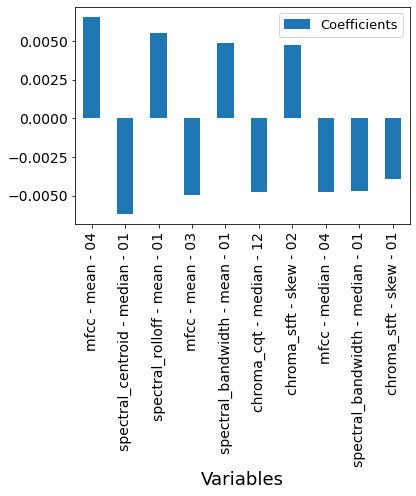

In [ ]:
# get importance - the mean of the coefficients b_{kj} across k classes
importance = LDA.coef_.mean(axis=0)   
d = {'Variables': variable_names, 'Coefficients': importance}
df = pd.DataFrame(data=d)
# reorder the coefficients by their absolute values
df = df.iloc[(-df['Coefficients'].abs()).argsort()]
print(df.head(10))
df_new = df.head(10)
df_new.plot.bar(x='Variables', y='Coefficients', fontsize=14, rot='vertical')
plt.legend(prop={'size': 13})
plt.show()